In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as ticker

from IPython.display import Audio
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from wordcloud import WordCloud

sns.set()
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

In [2]:
#Billboard Top 100 By Week from 1958 to 2021
bb100 = pd.read_csv('Hot Stuff.csv')

In [3]:
#Features
features = pd.read_excel('Hot 100 Audio Features.xlsx')

In [4]:
#First & Last 2 entries by Week/Year
bb100['WeekID'] = pd.DatetimeIndex(bb100['WeekID'])
#bb100.sort_values(by='WeekID').iloc[np.r_[0:2, -2:0]]

In [5]:
#Merge BB100 with Features
bb100_f = pd.merge(bb100, features, on='SongID', how='left')

In [6]:
#Getting Data From The 60's, 70's, 80's, 90's, 00's, 10's
bb60s_f = bb100_f[(bb100_f['WeekID'] >= '1960-1-1') & (bb100_f['WeekID'] < '1970-1-1')]
bb70s_f = bb100_f[(bb100_f['WeekID'] >= '1970-1-1') & (bb100_f['WeekID'] < '1980-1-1')]
bb80s_f = bb100_f[(bb100_f['WeekID'] >= '1980-1-1') & (bb100_f['WeekID'] < '1990-1-1')]
bb90s_f = bb100_f[(bb100_f['WeekID'] >= '1990-1-1') & (bb100_f['WeekID'] < '2000-1-1')]
bb2000s_f = bb100_f[(bb100_f['WeekID'] >= '2000-1-1') & (bb100_f['WeekID'] < '2010-1-1')]
bb2010s_f = bb100_f[(bb100_f['WeekID'] >= '2010-1-1') & (bb100_f['WeekID'] < '2020-1-1')]

In [34]:
#Splitting 3-ways:
bb67 = bb100_f[(bb100_f['WeekID'] >= '1960-1-1') & (bb100_f['WeekID'] < '1980-1-1')]
bb89 = bb100_f[(bb100_f['WeekID'] >= '1980-1-1') & (bb100_f['WeekID'] < '2000-1-1')]
bb01 = bb100_f[(bb100_f['WeekID'] >= '2000-1-1') & (bb100_f['WeekID'] < '2020-1-1')]

In [7]:
#Cross Check one results, the 60s:
bb60s_f.sort_values(by='WeekID').iloc[np.r_[0:2, -2:0]]

,url,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Performer_y,Song_y,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
243811,http://www.billboard.com/charts/hot-100/1960-01-02,1960-01-02,24,First Name Initial,Annette With The Afterbeats,First Name InitialAnnette With The Afterbeats,1,29.0,24,11,Annette With The Afterbeats,First Name Initial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251352,http://www.billboard.com/charts/hot-100/1960-01-02,1960-01-02,10,"Go, Jimmy, Go",Jimmy Clanton,"Go, Jimmy, GoJimmy Clanton",1,19.0,10,5,Jimmy Clanton,"Go, Jimmy, Go","['brill building pop', 'deep adult standards', 'doo-wop', 'rhythm and blues', 'rock-and-roll', 'swamp pop']",15mwNCoUIJJ1dvtNeSbY7J,https://p.scdn.co/mp3-preview/f369dc96b1aacff6f768e1fd53308a48c50a39f2?cid=b8d3901151d34489a160e3cf0ab1fa94,126426.0,0.0,Pop Megahits Of The 1950's - Volume 2,0.684,0.374,0.0,-12.037,1.0,0.0358,0.435,0.000000,0.131,0.846,142.815,4.0,14.0
229133,http://www.billboard.com/charts/hot-100/1969-12-27,1969-12-27,11,Midnight Cowboy,Ferrante & Teicher,Midnight CowboyFerrante & Teicher,1,15.0,11,9,Ferrante & Teicher,Midnight Cowboy,"['adult standards', 'easy listening', 'exotica', 'lounge']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210943,http://www.billboard.com/charts/hot-100/1969-12-27,1969-12-27,61,Midnight,Dennis Yost And The Classics IV,MidnightDennis Yost And The Classics IV,1,58.0,58,7,Dennis Yost And The Classics IV,Midnight,[],1iwcvFex3aq5mTosFFV2RG,NaN,174000.0,0.0,The Best Of Dennis Yost And The Classics IV,0.330,0.318,9.0,-10.777,0.0,0.0324,0.760,0.000001,0.172,0.467,121.306,4.0,1.0


In [8]:
#Convert "Spotify Genres" from Desired Dataframe to a Dict with Frequency Counter & Sorted List

def genre_df_to_dict_counter(df_column):
    
    clean_series = df_column.replace('[]', np.nan).dropna()
    
    new = []
    for item in clean_series:
        for ch in ['\\','`','*','_','{','}','[',']','(',')'
                   ,'>','#','+','.','!','$','\'']:

            if ch in item:
                item = item.replace(ch,'')
        new.append(item)
    
    messy_string = ', '.join(new)
    
    clean_string = [item.strip() for item in messy_string.split(',')]
    dict_counter = {k:clean_string.count(k) for k in set(clean_string)}
    sorted_list = sorted(dict_counter.items(), key=lambda x: x[1], reverse=True)
    
    return dict_counter, sorted_list;

In [25]:
#Create a WordCloud from Dictionary Frequency

def dict_counter_to_WC(dc_counter, mask=None):
    
    # WordCloud Object
    wordcloud = WordCloud(max_words=5, 
                          contour_width=3, 
                          width=650, height=425,
                          background_color="white",
                          colormap='Set2',
                          prefer_horizontal=0.95,
                          mask=mask
                         )
    
    # Generate a word cloud
    wordcloud.generate_from_frequencies(dc_counter)

    # Visualize the word cloud
    # print (wordcloud.words_)
    # print(wordcloud.layout_)
    return wordcloud.to_image()

## WordCloud for 60s

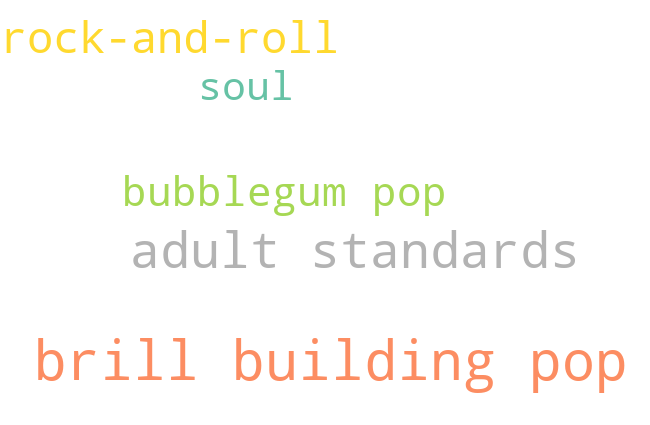

In [26]:
dc60s, sl60s = genre_df_to_dict_counter(bb60s_f['spotify_genre'])
#sl60s
dict_counter_to_WC(dc60s)

## WordCloud for 70s

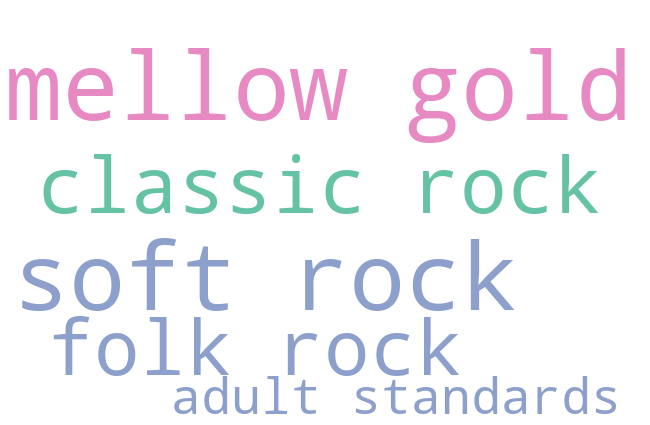

In [28]:
dc70s, sl70s = genre_df_to_dict_counter(bb70s_f['spotify_genre'])
#sl70s
dict_counter_to_WC(dc70s)

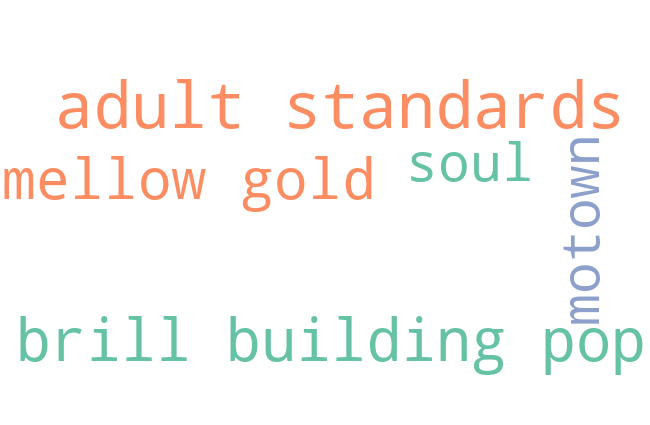

In [35]:
#60s + 70s

dc67s, sl67s = genre_df_to_dict_counter(bb67['spotify_genre'])
#sl70s
dict_counter_to_WC(dc67s)

## WordCloud for 80s

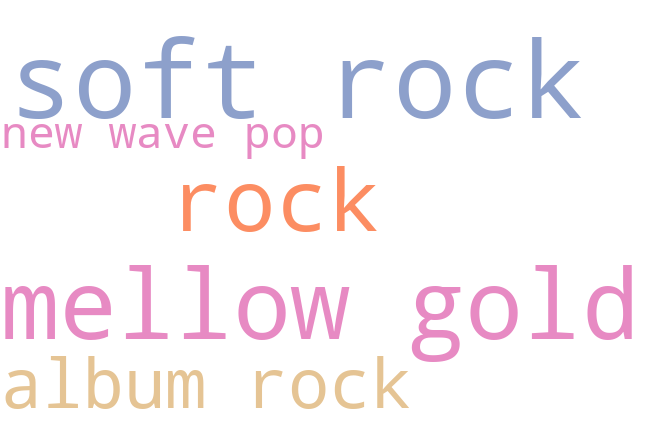

In [29]:
dc80s, sl80s = genre_df_to_dict_counter(bb80s_f['spotify_genre'])
#sl80s
dict_counter_to_WC(dc80s)

## WordCloud for 90s

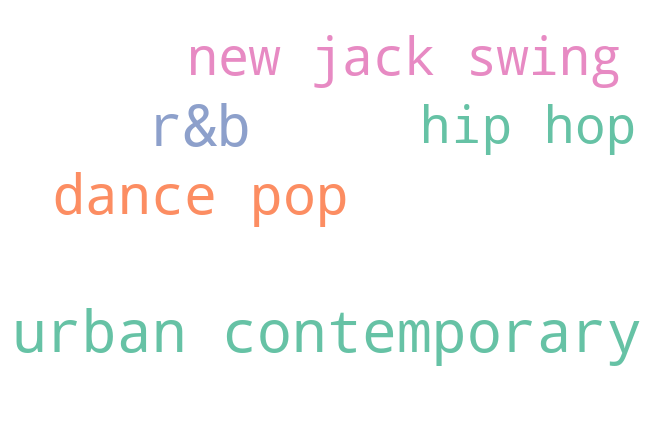

In [30]:
dc90s, sl90s = genre_df_to_dict_counter(bb90s_f['spotify_genre'])
#sl90s
dict_counter_to_WC(dc90s)

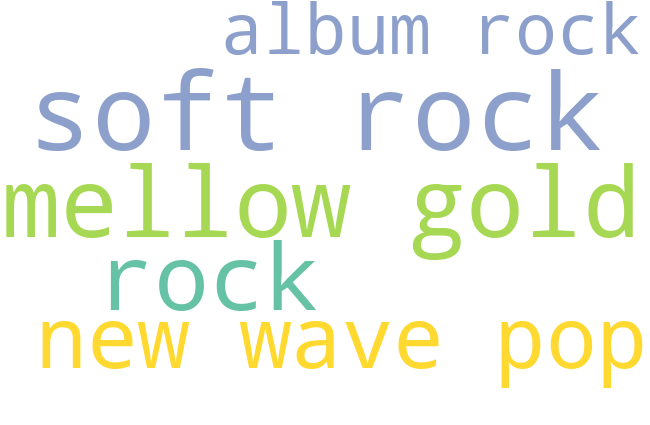

In [36]:
#80s + 90s

dc89s, sl89s = genre_df_to_dict_counter(bb89['spotify_genre'])
#sl70s
dict_counter_to_WC(dc89s)

## WordCloud for 2000s

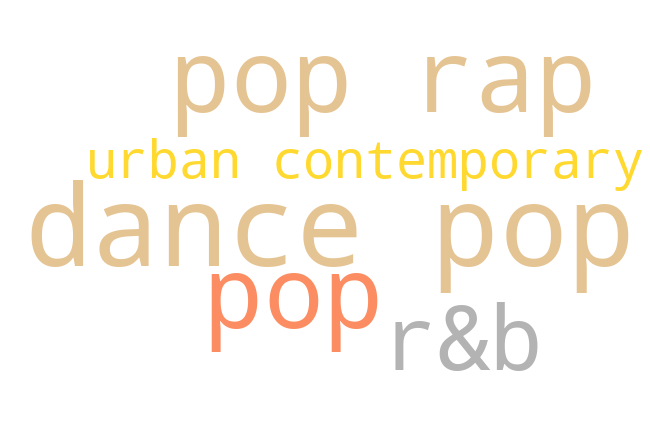

In [31]:
dc00s, sl00s = genre_df_to_dict_counter(bb2000s_f['spotify_genre'])
#sl00s
dict_counter_to_WC(dc00s)

## WordCloud for 2010s

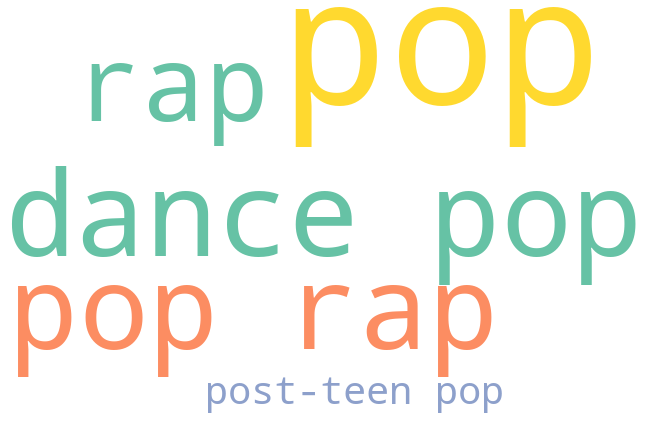

In [32]:
dc10s, sl10s = genre_df_to_dict_counter(bb2010s_f['spotify_genre'])
#sl10s
dict_counter_to_WC(dc10s)